In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# getting the Date
today = datetime.now().date()
start_date = datetime(today.year-5 ,today.month ,today.day).date()

In [4]:
#disconary of name of company and its ticker
ticker_dist = {"Google": "GOOGL",
              "Microsoft":"MSFT",
              "Tesla":"TSLA",
              "Amazon":"AMZN",
              "Netflix":"NFLX",
              "Apple":"AAPL",
              "Facebook":"META"}

In [5]:
for ticker in ticker_dist:
    filepath = "Resources/"+ ticker +".csv"
    globals()[ticker] = yf.download(ticker_dist[ticker], start=start_date, end=today)
    #globals()[ticker] = pdr.get_data_yahoo(ticker_dist[ticker], start=start_date, end=today)
    globals()[ticker].index = globals()[ticker].index.date
    globals()[ticker].index.name='Date'
    globals()[ticker].index = pd.to_datetime(globals()[ticker].index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
company_list= [Google,Microsoft,Tesla,Amazon,Netflix,Apple,Facebook] # which is df name and data is stored
company_name=["Google","Microsoft","Tesla","Amazon","Netflix","Apple","Facebook"] # which name we want to give them

In [7]:
df = Facebook

In [8]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Adj Close'])

In [9]:
# Convert the dataframe to a numpy array
dataset = data.values

In [10]:
# Get the number of rows to train the model on
# ceil is use for find nearer integer
training_data_len = int(np.ceil(len(dataset) * .90 ))

In [11]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [12]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast =  60 # length of output sequences (forecast period)

In [13]:
train_data = scaled_data[0:int(training_data_len), :]
len(train_data)

1133

In [14]:
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [15]:
len(x_train) , len(y_train)

(1073, 1073)

In [16]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1073, 60, 1)

In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (n_lookback, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1073/1073 [==============================] - 47s 38ms/step - loss: 0.0027


# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(x_train, y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [19]:
# Create the testing data set
# Create a new array containing scaled values from index
test_data = scaled_data[training_data_len - 60: , :]
len(test_data)

185

In [20]:
# Create the testing data set
# Create a new array containing scaled values from index
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
   
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

4/4 [==============================] - 1s 17ms/step


In [21]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
rmse

14.712973627164171

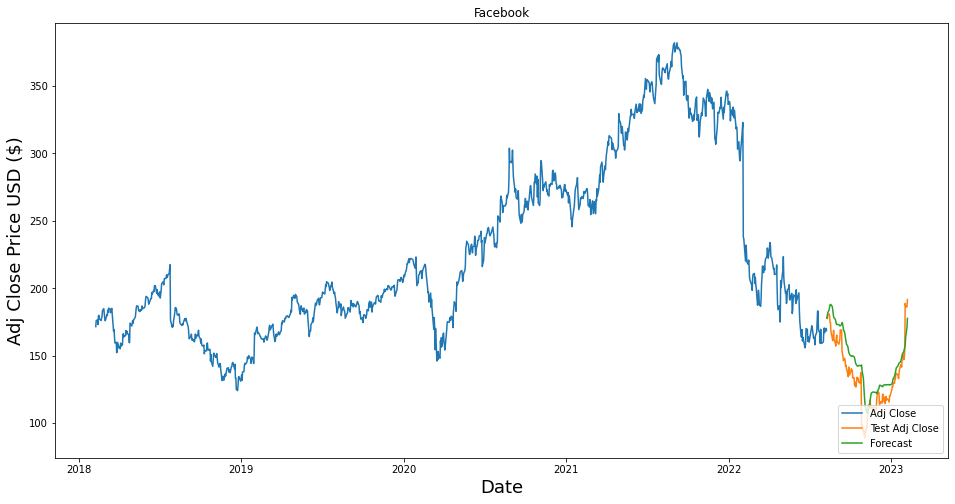

In [22]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Forecast'] = y_pred
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Facebook')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close', 'Forecast']])
plt.legend(['Adj Close', 'Test Adj Close', 'Forecast'], loc='lower right')
plt.show()

In [23]:
# Show the valid and predicted prices
test

,Adj Close,Forecast
Date,,
2022-08-10,178.339996,177.909180
2022-08-11,177.490005,179.836838
2022-08-12,180.500000,181.870193
2022-08-15,180.889999,184.089340
2022-08-16,179.470001,186.139420
...,...,...
2023-02-01,153.119995,156.088882
2023-02-02,188.770004,157.627029
2023-02-03,186.529999,163.704041


In [24]:
### Predicting the future price for next 3 months

In [25]:
# Split the data into x_train and y_train data sets
x_train_pred = []
y_train_pred = []

for i in range(n_lookback, len(scaled_data) - n_forecast + 1):
    x_train_pred.append(scaled_data[i - n_lookback: i])
    y_train_pred.append(scaled_data[i: i + n_forecast])

In [26]:
# Convert the x_train and y_train to numpy arrays 
x_train_pred, y_train_pred = np.array(x_train_pred), np.array(y_train_pred)

In [27]:
pred_model = Sequential()
pred_model.add(LSTM(50, return_sequences=True, input_shape= (n_lookback, 1)))
pred_model.add(LSTM(50, return_sequences=False))
pred_model.add(Dense(n_forecast))

pred_model.compile(loss='mean_squared_error', optimizer='adam')
pred_model.fit(x_train_pred, y_train_pred, epochs=100, batch_size=32, verbose=0)

In [29]:
# generate the forecasts
x_future_test = scaled_data[- n_lookback:]  # last available input sequence
x_future_test = x_future_test.reshape(1 , n_lookback, 1)
y_future_test = pred_model.predict(x_future_test).reshape(-1, 1)
y_future_test = scaler.inverse_transform(y_future_test)
y_future_test.shape

1/1 [==============================] - 1s 947ms/step


(60, 1)

In [30]:
df_past = train.append(test)
df_past['Forecast'].iloc[-1] = df_past['Adj Close'].iloc[-1]

In [31]:
from datetime import datetime, timedelta
df_future = pd.DataFrame(columns=['Date', 'Adj Close', 'Forecast'])
days = [datetime.now().date() + timedelta(days=i) for i in range(84)]
weekdays = [day for day in days if day.weekday() < 5]
df_future['Date'] = pd.DataFrame({'date': weekdays})
df_future['Date'] = pd.to_datetime(df_future['Date'])
df_future['Forecast'] = y_future_test.flatten()
df_future['Adj Close'] = np.nan
df_future.set_index('Date', inplace=True)
Results = df_past.append(df_future)

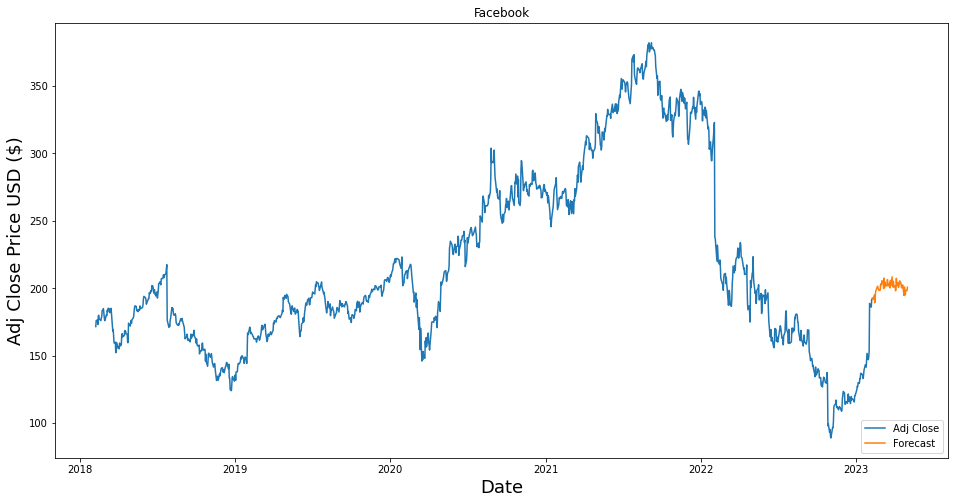

In [32]:
plt.figure(figsize=(16,8))
plt.title('Facebook')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price USD ($)', fontsize=18)
plt.plot(df_past['Adj Close'])
plt.plot(df_future['Forecast'])
plt.legend(['Adj Close', 'Forecast'], loc='lower right')
plt.show()

In [33]:
Results

,Adj Close,Forecast
Date,,
2018-02-08,171.580002,NaN
2018-02-09,176.110001,NaN
2018-02-12,176.410004,NaN
2018-02-13,173.149994,NaN
2018-02-14,179.520004,NaN
...,...,...
2023-04-26,NaN,198.267120
2023-04-27,NaN,195.090698
2023-04-28,NaN,198.458786
